In [42]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)


In [43]:
df = pd.read_csv('train.csv')

In [44]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [45]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [46]:
df["label"].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

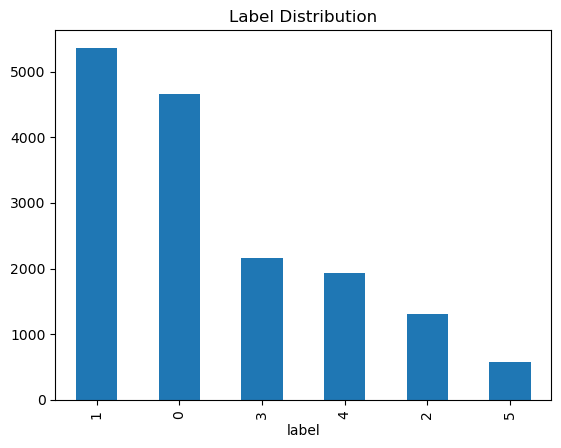

In [47]:
df["label"].value_counts().plot(kind="bar", title="Label Distribution")
plt.show()

In [48]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)


In [49]:
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [50]:
preprocessor = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)


In [51]:
models = {
    "LogisticRegression": (
        LogisticRegression(max_iter=2000, class_weight="balanced"),
        {"classifier__C": [0.01, 0.1, 1, 10]}
    ),

    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {"classifier__max_depth": [None, 5, 10, 15, 20]}
    ),

    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 10, 20]
        }
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.05, 0.1]
        }
    ),

    "SVM": (
        SVC(probability=True, class_weight="balanced"),
        {
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"]
        }
    ),

    "KNN": (
        KNeighborsClassifier(),
        {"classifier__n_neighbors": [3, 5, 7]}
    )
}


In [52]:
results = []

for name, (model, params) in models.items():

    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        cv=5,
        scoring="f1_weighted",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    result = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    }

    # ROC-AUC only if model supports probabilities
    if hasattr(best_model.named_steps["classifier"], "predict_proba"):
        y_prob = best_model.predict_proba(X_test)
        result["ROC-AUC"] = roc_auc_score(
            y_test,
            y_prob,
            multi_class="ovr",
            average="weighted"
        )
    else:
        result["ROC-AUC"] = None

    results.append(result)

    print(f"\n🔹 {name}")
    print("Best Params:", grid.best_params_)
    print(classification_report(y_test, y_pred))



🔹 LogisticRegression
Best Params: {'classifier__C': 1}
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       933
           1       0.93      0.89      0.91      1072
           2       0.74      0.94      0.83       261
           3       0.89      0.91      0.90       432
           4       0.89      0.84      0.86       387
           5       0.71      0.93      0.80       115

    accuracy                           0.89      3200
   macro avg       0.85      0.90      0.87      3200
weighted avg       0.90      0.89      0.90      3200


🔹 DecisionTree
Best Params: {'classifier__max_depth': None}
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       933
           1       0.88      0.89      0.89      1072
           2       0.80      0.75      0.78       261
           3       0.88      0.85      0.86       432
           4       0.83      0.88      0.85       387
           5   

In [58]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-score", ascending=False)


,Model,Best Params,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,LogisticRegression,{'classifier__C': 1},0.893750,0.900764,0.893750,0.895240,0.985392
4,SVM,"{'classifier__C': 1, 'classifier__kernel': 'li...",0.888437,0.897078,0.888437,0.890393,0.986436
2,RandomForest,"{'classifier__max_depth': None, 'classifier__n...",0.887813,0.887998,0.887813,0.887570,0.985798
3,GradientBoosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.869687,0.874426,0.869687,0.870200,0.978288
1,DecisionTree,{'classifier__max_depth': None},0.870313,0.870146,0.870313,0.870016,0.918897
5,KNN,{'classifier__n_neighbors': 7},0.726562,0.737509,0.726562,0.717488,0.905613


Best Model: LogisticRegression


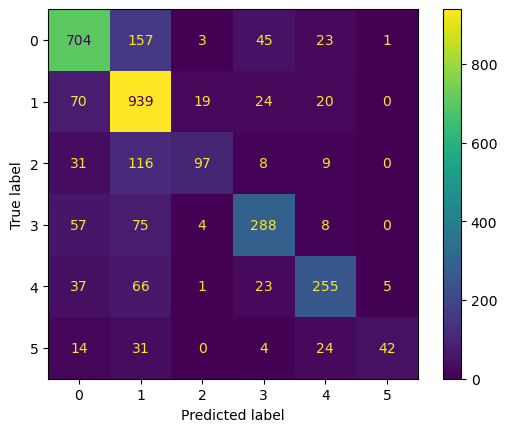

In [59]:
best_index = results_df["F1-score"].idxmax()
best_model_name = results_df.loc[best_index, "Model"]

print("Best Model:", best_model_name)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
